# Full Pipeline Automatic Extractive Text Summarization

Test Data through pipeline

# Set-up

In [1]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# CD to correct folder 
!cd "/content/drive/MyDrive/Colab_Notebooks/Thesis/"

# Initialize path
import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/Thesis/')

In [3]:
# Set-up GPU for training
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [4]:
%%capture
# Pip install packages
!pip install transformers
!pip install bert-extractive-summarizer
!pip install sacremoses

!pip install -U sentence-transformers

# Download 
!python -m spacy download en_core_web_lg

In [5]:
%%capture
# Import packages
# Import general packages
import pandas as pd
import numpy as np

from pprint import pprint
from tabulate import tabulate
import random
import time

# Torch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

# Regex
import re

# NLTK
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# MatplotLib
import matplotlib
import matplotlib.pyplot as plt

# Seaborn
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

# Sklearn
import sklearn
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import utils

# Spacy
import spacy
import en_core_web_lg

# Transformers
import transformers
from transformers import BertTokenizer
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
from summarizer import Summarizer
from summarizer.sbert import SBertSummarizer

# Gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from gensim.summarization.textcleaner import get_sentences, split_sentences
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim.matutils import kullback_leibler


# Functions
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Load Data

In [6]:
# Define path Data
path = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Data/"

## Train Test Split

In [ ]:
# ---------- FULL DATA SET ----------
df_euans_total = pd.read_excel(path + 'reviews_per_aspect.xlsx')

In [ ]:
# Shuffle data
df_shuffle = df_euans_total.sample(frac=1)

# Train data (80%)
train_data = df_shuffle[:int(df_shuffle.shape[0]*0.8)]

# Test data (20%)
test_data = df_shuffle[int(df_shuffle.shape[0]*0.8):]

print("Length of train_data should be:", int(df_shuffle.shape[0]*0.8))
print("Length of test_data should be:", int(df_shuffle.shape[0]*0.2))

# Save cleaned data
train_data.to_csv(path+"train_data.csv")
test_data.to_csv(path+"test_data.csv")

Length of train_data should be: 68244
Length of test_data should be: 17061


In [ ]:
print("Length of train_data: ", train_data.shape[0])
print("Length of test_data: ", test_data.shape[0])

Length of train_data:  68244
Length of test_data:  17062


## Load Data from train and test

In [7]:
# ---------- TRAIN & TEST DATA ----------
train_data = pd.read_csv(path + 'train_data.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 55920, 1: 1550
test_data = pd.read_csv(path + 'test_data.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 6977, 1: 2395

## Load cleaned data

In [ ]:
train_data_cleaned = pd.read_csv(path + 'train_data_cleaned.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 55920, 1: 1550
test_data_cleaned = pd.read_csv(path + 'test_data_cleaned.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 6977, 1: 2395

X_train= pd.read_csv(path + 'X_train.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 55920, 1: 1550
y_train_aspect = pd.read_csv(path + 'y_train_aspect.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 6977, 1: 2395
y_train_sent = pd.read_csv(path + 'y_train_sent.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 55920, 1: 1550
X_test = pd.read_csv(path + 'X_test.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 6977, 1: 2395
y_test_aspect = pd.read_csv(path + 'y_test_aspect.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 55920, 1: 1550
y_test_sent = pd.read_csv(path + 'y_test_sent.csv').rename(columns={"Unnamed: 0": "Index"}) #0: 6977, 1: 2395


FileNotFoundError: ignored

# Cleaning

In [8]:
def cleaning_df(df):
    # --------- CLEAN DATA ---------
    print(color.BOLD + "---> START CLEANING" + color.END) 
    # Rename and drop colums
    df = df.drop(columns=["City", "Country"])
    df = df.rename(columns={"Review": "Text"})

    # Drop irrelevant aspects
    df = df[df['Aspect']!='Anything else you wish to tell us?']
    df = df[df['Aspect']!='Venue Manager responded to this review']       
    df = df[df['Aspect']!='COVID Precautions']  
    df = df[df['Aspect']!='Accessibility Guide']  
    df = df[df['Aspect']!='Awards List'] 
    df = df[df['Aspect']!='Access Statement']

    # Drop NaN
    df = df[df["Text"].notna()]
    df["Text"] = df["Text"].apply(lambda x: x.replace("\n", ' '))

    # Some reviews contain: "A description about the access has not been added for this venue."
    # These have a rating <=0.0
    # Remove no description reviews
    df = df[df["Rating"]>0.0]

    # Remove review if sentence count == 0
    df["SentenceCount"] = df["Text"].apply(lambda x: len(sent_tokenize(x)))
    df = df[df["SentenceCount"]!=0]
    df = df.drop(columns=["SentenceCount"])

    # Take only the venue name
    df["Venue"] = df["Venue"].apply(lambda x: ' '.join(x.split('|')[4].split("-")[:-1]))

    # Tokenize into sentences: regEX
    #rule = r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s"
    #df["Text"] = df["Text"].apply(lambda x: re.split(rule, x))
    #df = df.explode("Text", ignore_index=True)

    # Rating into Sentiment
    df["Sentiment"] = df["Rating"].map(lambda score: 'positive' if score > 3.0 else 'negative')
    df['Label'] = df["Sentiment"].map({'positive': 1, 'negative': 0})

    df["Target"] = df.Aspect.astype('category').cat.codes

    print("---> DONE CLEANING")
    return df

In [9]:
train_data_cleaned = cleaning_df(train_data)
X_train = train_data_cleaned.Text.values
y_train_aspect = train_data_cleaned.Aspect.values
y_train_target = train_data_cleaned.Target.values
y_train_sent = train_data_cleaned.Label.values
print("Length of test_data_cleaned: ", train_data_cleaned.shape[0])

# 97748 sentences
# 31969 reviews

train_data_cleaned.head(3)

---> START CLEANING
---> DONE CLEANING
Length of test_data_cleaned:  31969


,Index,Aspect,Rating,Text,Venue,Sentiment,Label,Target
0,55920,Toilets,2.0,"There is an accessible toilet. It's OK, and do...",holland park london,negative,0,3
6,18620,Overview,5.0,We enjoyed our visit a lot and had no accessib...,hula juice bar healthy eatery edinburgh,positive,1,1
7,47677,Staff,5.0,"All friendly and helpful, but three cheers in ...",vindolanda hexham,positive,1,2


In [34]:
int(train_data_cleaned.shape[0]*0.9) # ===> 

28772

In [35]:
val_data_cleaned = train_data_cleaned[:28772]
X_val = val_data_cleaned.Text.values
y_val_aspect = val_data_cleaned.Aspect.values
y_val_target = val_data_cleaned.Target.values
y_val_sent = val_data_cleaned.Label.values

In [10]:
test_data_cleaned = cleaning_df(test_data)
X_test = test_data_cleaned.Text.values
y_test_aspect = test_data_cleaned.Aspect.values
y_test_target = test_data_cleaned.Target.values
y_test_sent = test_data_cleaned.Label.values
print("Length of test_data_cleaned: ", test_data_cleaned.shape[0])

# 25138 sentences
# 8055 reviews

test_data_cleaned.head(3)

---> START CLEANING
---> DONE CLEANING
Length of test_data_cleaned:  8055


,Index,Aspect,Rating,Text,Venue,Sentiment,Label,Target
0,6977,Toilets,5.0,plenty of accessible toilets available,barbican centre london,positive,1,3
1,53897,Overview,4.0,Access to the cottages is via a driveway shar...,homelands trust fife lundin links,positive,1,1
4,2395,Staff,5.0,The staff were very helpful and friendly . T...,black ivy edinburgh,positive,1,2


In [11]:
results_text = dict()             # text classification results
results_sentiment = dict()        # sentiment analysis results
results_summary = dict()          # summary results

results_text_BERT = dict()        # text classification results BERT
results_sentiment_BERT = dict()   # sentiment analysis results BERT
results_summary_BERT = dict()     # summary results BERT

In [12]:
# Save cleaned data
train_data_cleaned.to_csv(path+"train_data_cleaned.csv")
test_data_cleaned.to_csv(path+"test_data_cleaned.csv")

pd.DataFrame(X_train).to_csv(path+'X_train.csv')
pd.DataFrame(y_train_aspect).to_csv(path+'y_train_aspect.csv')
pd.DataFrame(y_train_sent).to_csv(path+'y_train_sent.csv')

pd.DataFrame(X_test).to_csv(path+'X_test.csv')
pd.DataFrame(y_test_aspect).to_csv(path+'y_test_aspect.csv')
pd.DataFrame(y_test_sent).to_csv(path+'y_test_sent.csv')

# EDA

In [ ]:
#----------EDA----------
print(color.BOLD + "---> START EDA" + color.END)

#====================
#=====PER ASPECT=====
#====================
print(color.BOLD + "REVIEWS PER ASPECT:" + color.END)
# Reviews
review_counts = df['Aspect'].value_counts()

review_metrics = [["Total nr. of reviews:", review_counts.sum()], 
                    ["Max nr. of reviews per aspect:", review_counts.max()], 
                    ["Min nr. of reviews per aspect:", review_counts.min()], 
                    ["Average nr. of reviews per aspect:", review_counts.mean()]]
col_names = ["Metric", "Count"]
print(tabulate(review_metrics, headers=col_names))

plt.figure(figsize=(8,4))
sns.barplot(review_counts.index, review_counts.values, alpha=0.8)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xlabel('Aspect', fontsize=12)
plt.ylim(0, 10000)

# Sentences per aspect
print(color.BOLD + "SENTENCES PER ASPECT:" + color.END)
sentence_counts = dict()
for aspect in df["Aspect"].unique():
    temp = df[df["Aspect"]==aspect]
    sentence_counts[aspect] = temp["SentenceCount"].mean()

print(color.BOLD + "Average nr. of sentences per aspect" + color.END)
pprint(sentence_counts)

# Sentences per review
print(color.BOLD + "SENTENCES PER REVIEW:" + color.END)
sentence_metrics = [["Total nr. of sentences:", df["SentenceCount"].sum()], 
                    ["Max nr. of sentences per review:", df["SentenceCount"].max()], 
                    ["Min nr. of sentences per review:", df["SentenceCount"].min()], 
                    ["Average nr. of sentences per review:", df["SentenceCount"].mean()]]
col_names = ["Metric", "Count"]
print(tabulate(sentence_metrics, headers=col_names))

#====================
#=====PER VENUE=====
#====================
print(color.BOLD + "REVIEWS PER VENUE:" + color.END)
review_count_per_venue = df['Venue'].value_counts()

print(color.BOLD + "Review EDA:" + color.END)
review_metrics_per_venue = [["Total nr. of reviews:", int(review_count_per_venue.sum())], 
                            ["Max nr. of reviews per venue:", review_count_per_venue.max()], 
                            ["Min nr. of reviews per venue:", review_count_per_venue.min()], 
                            ["Average nr. of reviews per venue:", review_count_per_venue.mean()]]
col_names = ["Metric", "Count"]
print(tabulate(review_metrics_per_venue, headers=col_names))

#====================
#=====PER RATING=====
#====================
print(color.BOLD + "REVIEWS PER RATING:" + color.END)
rating_counts = df['Rating'].value_counts()
plt.figure(figsize=(8,4))
ax = sns.barplot(rating_counts.index, rating_counts.values, alpha=0.8)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xlabel('Rating', fontsize=12)
plt.ylim(0, 16000)
plt.show();

print(color.BOLD + "REVIEWS PER SENTIMENT:" + color.END)
sentiment_count = df['Sentiment'].value_counts()
plt.figure(figsize=(8,4))
ax = sns.barplot(sentiment_count.index, sentiment_count.values, alpha=0.8)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.ylim(0, 35000)
plt.show();

# Pre-processing

## Classical Machine Learning

In [37]:
# Pre-processing for Machine Learning
def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Remove URLs
    - Change "'t" to "not"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Remove URLs
    s = re.sub(r"http.*?(?=\s)", "", s) 
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

In [52]:
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])

In [53]:
# Pipeline with Doc2Vec
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

def doc2vec_preprocessing(text):
    text = str(text)
    text = text.lower()  
    text = text.replace("\n", '')                            # Remove \n
    text = re.sub("n’t", ' not', text)                       # Change n't to not
    text = re.sub("'re", ' are', text)                       # Change 're to are
    text = re.sub(r'[^\w\s]', '', text)                      # Remove punctuation
    text = re.sub(" +", " ", text)                           # Remove multiple spaces
    text = re.sub(r"http.*?(?=\s)", "", text)                # Remove URL's
    text = re.sub("'"," ", text)                             # Remove apostrophes

    return text

In [58]:
# Vectorization Doc2Vec
from sklearn import utils
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

X_train_doc2vec = [doc2vec_preprocessing(text) for text in X_train_preprocessed]
X_test_doc2vec = [doc2vec_preprocessing(text) for text in X_test_preprocessed]

print(color.BOLD + "Support Vector Machines with Doc2Vec" + color.END)
X_train_label = label_sentences(X_train_doc2vec, 'Train')
X_test_label = label_sentences(X_test_doc2vec, 'Test')
all_data = X_train_label + X_test_label

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train_label), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test_label), 300, 'Test')

Support Vector Machines with Doc2Vec


100%|██████████| 40024/40024 [00:00<00:00, 2727244.75it/s]


## Confuson Matrices

In [54]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    
    return accuracy, precision, recall, f1_score

# Text Classification

In [ ]:
y_train_aspect

array(['Toilets', 'Toilets', 'Toilets', ..., 'Staff', 'Staff', 'Access'],
      dtype=object)

## Machine Learning

Naive Bayes (tf-idf)
Accuracy:
0.8355058969584109
Weighted avg:
{'f1-score': 0.8376427553236141,
 'precision': 0.8435886834502052,
 'recall': 0.8355058969584109,
 'support': 8055}
Support Vector Machines (tf-idf)
Accuracy:
0.870391061452514
Weighted avg:
{'f1-score': 0.8695974766773238,
 'precision': 0.8696915238417985,
 'recall': 0.870391061452514,
 'support': 8055}
Logistic Regression (tf-idf)
Accuracy:
0.8078212290502793
Weighted avg:
{'f1-score': 0.8078217932541001,
 'precision': 0.8079034865318843,
 'recall': 0.8078212290502793,
 'support': 8055}


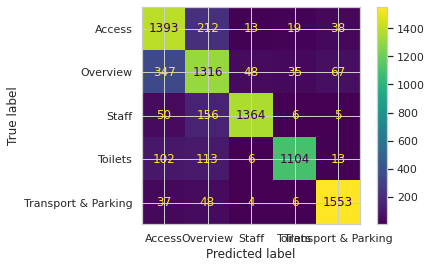

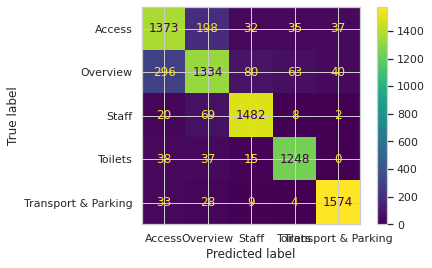

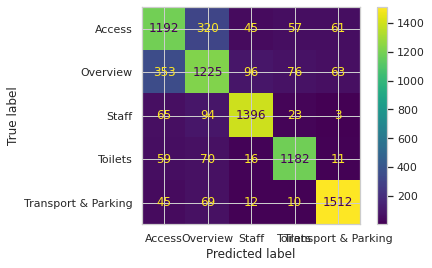

In [73]:
#==============================
#===== TEST TF-IDF ML MODELS =====
#==============================

# MultinomialNB (alpha=1.0)
print(color.BOLD + "Naive Bayes (tf-idf)" + color.END)
nb = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=1.0))
                ])
nb.fit(X_train_preprocessed, y_train_aspect)
y_pred = nb.predict(X_test_preprocessed)
plot_confusion_matrix(nb, X_test_preprocessed, y_test_aspect)

metrics_nb = classification_report(y_test_aspect, y_pred, output_dict=True) #y_true, y_pred
results_text["NB(tfidf)"] = metrics_nb
print("Accuracy:")
pprint(results_text["NB(tfidf)"]['accuracy'])
print("Weighted avg:")
pprint(results_text["NB(tfidf)"]['weighted avg'])

# Support Vector Machines (kernel=linear)
print(color.BOLD + "Support Vector Machines (tf-idf)" + color.END)
clf = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', svm.SVC(kernel='linear'))
                ])
clf.fit(X_train_preprocessed, y_train_aspect)
y_pred = clf.predict(X_test_preprocessed)
plot_confusion_matrix(clf, X_test_preprocessed, y_test_aspect)

metrics_svm = classification_report(y_test_aspect, y_pred, output_dict=True)
results_text["SVM(tfidf)"] = metrics_svm
print("Accuracy:")
pprint(results_text["SVM(tfidf)"]['accuracy'])
print("Weighted avg:")
pprint(results_text["SVM(tfidf)"]['weighted avg'])

# Logistic Regression
print(color.BOLD + "Logistic Regression (tf-idf)" + color.END)
logreg = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='sag'))
                ])
logreg.fit(X_train_preprocessed, y_train_aspect)
y_pred = logreg.predict(X_test_preprocessed)
plot_confusion_matrix(logreg, X_test_preprocessed, y_test_aspect)

metrics_logreg = classification_report(y_test_aspect, y_pred, output_dict=True)
results_text["LogReg(tfidf)"] = metrics_logreg
print("Accuracy:")
pprint(results_text["LogReg(tfidf)"]['accuracy'])
print("Weighted avg:")
pprint(results_text["LogReg(tfidf)"]['weighted avg'])

Support Vector Machines (Doc2Vec)
Accuracy:
0.8414649286157666
Weighted avg:
{'f1-score': 0.8400970919586139,
 'precision': 0.8403861115382688,
 'recall': 0.8414649286157666,
 'support': 8055}


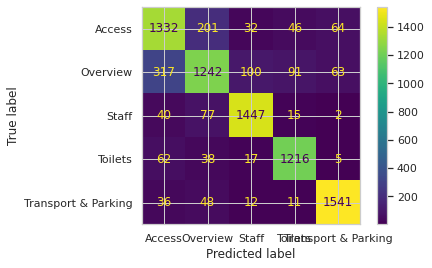

In [74]:
# SVM, kernel=linear
print(color.BOLD + "Support Vector Machines (Doc2Vec)" + color.END)
clf = svm.SVC(kernel='linear')
clf.fit(train_vectors_dbow, y_train_aspect)
y_pred = clf.predict(test_vectors_dbow)
plot_confusion_matrix(clf, test_vectors_dbow, y_test_aspect)

metrics_svm_doc2vec = classification_report(y_test_aspect, y_pred, output_dict=True)
results_text["SVM(doc2vec)"] = metrics_svm_doc2vec
print("Accuracy:")
pprint(results_text["SVM(doc2vec)"]['accuracy'])
print("Weighted avg:")
pprint(results_text["SVM(doc2vec)"]['weighted avg'])

#total_vectors_dbow = np.concatenate((train_vectors_dbow, test_vectors_dbow))

## Unsupervised

In [55]:
def embed(tokens, nlp):
    """Return the centroid of the embeddings for the given tokens.

    Out-of-vocabulary tokens are cast aside. Stop words are also
    discarded. An array of 0s is returned if none of the tokens
    are valid.

    """

    lexemes = (nlp.vocab[token] for token in tokens)

    vectors = np.asarray([
        lexeme.vector
        for lexeme in lexemes
        if lexeme.has_vector
        and not lexeme.is_stop
        and len(lexeme.text) > 1
    ])

    if len(vectors) > 0:
        centroid = vectors.mean(axis=0)
    else:
        width = nlp.meta['vectors']['width']  # typically 300
        centroid = np.zeros(width)

    return centroid
  
def predict_closest_label(text, nlp, neigh):
    text = lemmatizer.lemmatize(text)
    text = word_tokenize(text)
    text = ' '.join([word for word in text if word not in stop_words])

    tokens = text.split(' ')
    centroid = embed(tokens, nlp)
    closest_label = neigh.kneighbors([centroid], return_distance=False)[0][0]
    
    return closest_label

In [60]:
y_train_topic = train_data_cleaned["Aspect"].apply(lambda x: x.lower())
y_test_topic = test_data_cleaned["Aspect"].apply(lambda x: x.lower())

In [232]:
# Unsupervised
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import balanced_accuracy_score
print(color.BOLD + "---> START TOPIC CLASSIFICATION: Unsupervised" + color.END)

topic_list = ["overview", "access", "transport & parking", "staff", "toilets", ]

print("Euclidean distance ")
nlp = en_core_web_lg.load()
neigh = NearestNeighbors(n_neighbors=1)
topic_vectors = np.asarray([embed(topic.split(' '), nlp) for topic in topic_list])
neigh.fit(topic_vectors)

predict_topics = [topic_list[predict_closest_label(text, nlp, neigh)] for text in X_test]

#plot_confusion_matrix(clf, predict_topics, y_test_aspect)

metrics_unsupervised_EU = classification_report(y_test_topic, predict_topics, output_dict=True)
results_text["Unsupervised_EU"] = metrics_unsupervised_EU
print("Accuracy:")
pprint(results_text["Unsupervised_EU"]['accuracy'])
print("Weighted avg:")
pprint(results_text["Unsupervised_EU"]['weighted avg'])
print("Balanced Accuracy:", balanced_accuracy_score(y_test_topic, predict_topics))

print("---> DONE TOPIC CLASSIFICATION")

from scipy import spatial
print("Cosine similarity ")
neigh = NearestNeighbors(n_neighbors=1, metric=spatial.distance.cosine)
topic_vectors = np.asarray([embed(topic.split(' '), nlp) for topic in topic_list])
neigh.fit(topic_vectors)

predict_topics = [topic_list[predict_closest_label(text, nlp, neigh)] for text in X_test]

#plot_confusion_matrix(clf, predict_topics, y_test_aspect)

metrics_unsupervised_COS = classification_report(y_test_topic, predict_topics, output_dict=True)
results_text["Unsupervised_COS"] = metrics_unsupervised_COS
print("Accuracy:")
pprint(results_text["Unsupervised_COS"]['accuracy'])
print("Weighted avg:")
pprint(results_text["Unsupervised_COS"]['weighted avg'])
print("Balanced Accuracy:", balanced_accuracy_score(y_test_topic, predict_topics))

print("---> DONE TOPIC CLASSIFICATION")

---> START TOPIC CLASSIFICATION: Unsupervised
Euclidean distance 
Accuracy:
0.35083798882681566
Weighted avg:
{'f1-score': 0.2746997191614271,
 'precision': 0.5603731937560635,
 'recall': 0.35083798882681566,
 'support': 8055}
Balanced Accuracy: 0.3486085654315369
---> DONE TOPIC CLASSIFICATION
Cosine similarity 
Accuracy:
0.5021725636250776
Weighted avg:
{'f1-score': 0.43125945828965,
 'precision': 0.4994660072654595,
 'recall': 0.5021725636250776,
 'support': 8055}
Balanced Accuracy: 0.5098692862615435
---> DONE TOPIC CLASSIFICATION


## Save data

In [76]:
# Save data
#model_names = ['NB (tfidf)', 'SVM (tf-idf)', 'LogReg (tf-idf)', 'SVM (doc2vec)', 'Unsupervised']

results_df = pd.DataFrame(results_text).transpose()

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/results_text_review_level.xlsx')

results_df.to_excel(writer, sheet_name="text_classification")

writer.save()

## BERT

In [27]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")

print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [28]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] I will watch Memento tonight [SEP] [PAD] [PAD]


### Pre-trained

In [32]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'Overview':0,
          'Access':1,
          'Transport & Parking':2,
          'Staff':3,
          'Toilets':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Aspect']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [30]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [36]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 2
model = BertClassifier()
LR = 1e-6
              
train(model, train_data_cleaned, val_data_cleaned, LR, EPOCHS) # val accuracy = 0.939

100%|██████████| 15985/15985 [35:03<00:00,  7.60it/s]


Epochs: 1 | Train Loss:  0.307                 | Train Accuracy:  0.785                 | Val Loss:  0.137                 | Val Accuracy:  0.915


100%|██████████| 15985/15985 [35:00<00:00,  7.61it/s]


Epochs: 2 | Train Loss:  0.131                 | Train Accuracy:  0.914                 | Val Loss:  0.102                 | Val Accuracy:  0.939


In [50]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    accuracy = total_acc_test / len(test_data)

    #metrics = classification_report(test_label, output.argmax(dim=1), output_dict=True)
    
evaluate(model, test_data_cleaned)

# Test Accuracy:  0.911

Test Accuracy:  0.911


In [51]:
results_text['BERT pre-trained'] = 0.911

## Save the results

In [70]:
# Save data
#model_names = ['NB (tfidf)', 'SVM (tf-idf)', 'LogReg (tf-idf)', 'SVM (doc2vec)', 'Unsupervised', 'BERT pre-trained']

results_df = pd.DataFrame(results_text).transpose()

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/results_text_review_level.xlsx')

results_df.to_excel(writer, sheet_name="text_classification")

writer.save()

## Final Text Predictions

In [ ]:
# Final predictions on test data from best model
aspect_pred_final = 

# Senitment Analysis

## Classical Machine Learning

Naive Bayes (tf-idf)
Accuracy:
0.7995034140285537
Weighted avg:
{'f1-score': 0.7126382786487321,
 'precision': 0.8397923261031943,
 'recall': 0.7995034140285537,
 'support': 8055}
Support Vector Machines (tf-idf)
Accuracy:
0.819366852886406
Weighted avg:
{'f1-score': 0.7825807463087554,
 'precision': 0.7962266500916921,
 'recall': 0.819366852886406,
 'support': 8055}
Logistic Regression (tf-idf)
Accuracy:
0.7752948479205463
Weighted avg:
{'f1-score': 0.7704740069956404,
 'precision': 0.7664325385035571,
 'recall': 0.7752948479205463,
 'support': 8055}


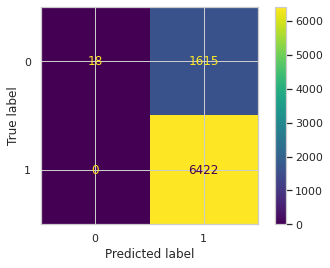

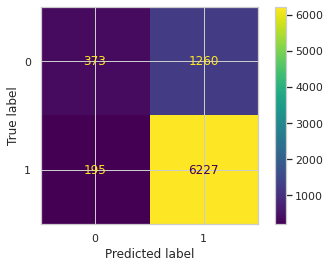

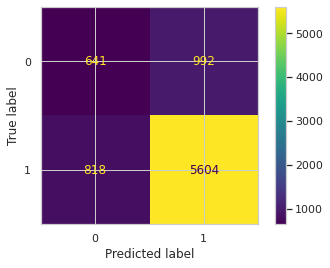

In [77]:
#==============================
#===== TEST TF-IDF ML MODELS =====
#==============================

# MultinomialNB (alpha=1.0)
print(color.BOLD + "Naive Bayes (tf-idf)" + color.END)
nb = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=1.0))
                ])
nb.fit(X_train_preprocessed, y_train_sent)
y_pred = nb.predict(X_test_preprocessed)
plot_confusion_matrix(nb, X_test_preprocessed, y_test_sent)

metrics_nb = classification_report(y_test_sent, y_pred, output_dict=True) #y_true, y_pred
results_sentiment["NB(tfidf)"] = metrics_nb
print("Accuracy:")
pprint(results_sentiment["NB(tfidf)"]['accuracy'])
print("Weighted avg:")
pprint(results_sentiment["NB(tfidf)"]['weighted avg'])

# Support Vector Machines (kernel=linear)
print(color.BOLD + "Support Vector Machines (tf-idf)" + color.END)
clf = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', svm.SVC(kernel='linear'))
                ])
clf.fit(X_train_preprocessed, y_train_sent)
y_pred = clf.predict(X_test_preprocessed)
plot_confusion_matrix(clf, X_test_preprocessed, y_test_sent)

metrics_svm = classification_report(y_test_sent, y_pred, output_dict=True)
results_sentiment["SVM(tfidf)"] = metrics_svm
print("Accuracy:")
pprint(results_sentiment["SVM(tfidf)"]['accuracy'])
print("Weighted avg:")
pprint(results_sentiment["SVM(tfidf)"]['weighted avg'])

# Logistic Regression
print(color.BOLD + "Logistic Regression (tf-idf)" + color.END)
logreg = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='sag'))
                ])
logreg.fit(X_train_preprocessed, y_train_sent)
y_pred = logreg.predict(X_test_preprocessed)
plot_confusion_matrix(logreg, X_test_preprocessed, y_test_sent)

metrics_logreg = classification_report(y_test_sent, y_pred, output_dict=True)
results_sentiment["LogReg(tfidf)"] = metrics_logreg
print("Accuracy:")
pprint(results_sentiment["LogReg(tfidf)"]['accuracy'])
print("Weighted avg:")
pprint(results_sentiment["LogReg(tfidf)"]['weighted avg'])

Support Vector Machines (Doc2Vec)
Accuracy:
0.7972687771570454
Weighted avg:
{'f1-score': 0.7073371674936169,
 'precision': 0.6356375030294905,
 'recall': 0.7972687771570454,
 'support': 8055}


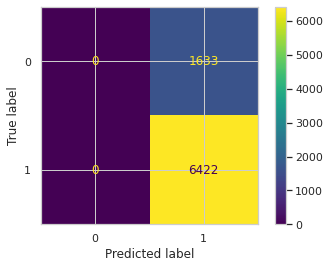

In [78]:
# SVM, kernel=linear
print(color.BOLD + "Support Vector Machines (Doc2Vec)" + color.END)
clf = svm.SVC(kernel='linear')
clf.fit(train_vectors_dbow, y_train_sent)
y_pred = clf.predict(test_vectors_dbow)
plot_confusion_matrix(clf, test_vectors_dbow, y_test_sent)

metrics_svm_doc2vec = classification_report(y_test_sent, y_pred, output_dict=True)
results_sentiment["SVM(doc2vec)"] = metrics_svm_doc2vec
print("Accuracy:")
pprint(results_sentiment["SVM(doc2vec)"]['accuracy'])
print("Weighted avg:")
pprint(results_sentiment["SVM(doc2vec)"]['weighted avg'])

## Unsupervised Vader Sentiment

In [79]:
# VADER SENTIMENT
!pip install vaderSentiment
from nltk.sentiment import SentimentIntensityAnalyzer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    #print("{:-<40} {}".format(sentence, str(score)))
    return score

def is_positive(text):
    '''True if text has positive compound sentiment, False otherwise.'''
    sentiment_score = sentiment_analyzer_scores(text)

    if sentiment_score["compound"] > 0:
      return 1
    else:
      return 0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 8.0 MB/s 


Vader Sentiment
Accuracy:
0.6823091247672253
Weighted avg:
{'f1-score': 0.705281213350676,
 'precision': 0.7444904605032178,
 'recall': 0.6823091247672253,
 'support': 8055}


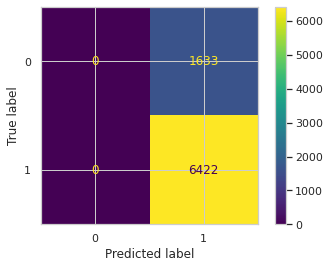

In [81]:
# Vader Sentiment
print(color.BOLD + "Vader Sentiment" + color.END)
y_pred = [is_positive(text) for text in X_test]

plot_confusion_matrix(clf, test_vectors_dbow, y_test_sent)

metrics_vader_sent = classification_report(y_test_sent, y_pred, output_dict=True)
results_sentiment["vader_sent"] = metrics_vader_sent
print("Accuracy:")
pprint(results_sentiment["vader_sent"]['accuracy'])
print("Weighted avg:")
pprint(results_sentiment["vader_sent"]['weighted avg'])

In [83]:
# Save data
#model_names = ['NB (tfidf)', 'SVM (tf-idf)', 'LogReg (tf-idf)', 'SVM (doc2vec)', 'Vader']

results_sentiment_df = pd.DataFrame(results_sentiment).transpose()

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/results_sentiment_review_level.xlsx')

results_sentiment_df.to_excel(writer, sheet_name="sentiment_analysis")

writer.save()

## BERT

In [84]:
# Pre-process with BERT
def BERT_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=BERT_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [88]:
# Before tokenizing, we need to specify the maximum length of our sentences.

# Concatenate train data and test data
all_reviews = np.concatenate([train_data_cleaned.Text.values, test_data_cleaned.Text.values])

# Encode our concatenated data
encoded_reviews = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_reviews]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_reviews])
print('Max length: ', max_len)

# Specify `MAX_LEN`
MAX_LEN = 100

# Print sentence 0 and its encoded token ids
#token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
#print('Original: ', X[0])
#print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
test_inputs, test_masks = preprocessing_for_bert(X_test)

Max length:  1779
Tokenizing data...


In [89]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train_sent)
test_labels = torch.tensor(y_test_sent)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data_bert = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data_bert)
train_dataloader = DataLoader(train_data_bert, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
test_data_bert = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data_bert)
test_dataloader = DataLoader(test_data_bert, sampler=test_sampler, batch_size=batch_size)

In [90]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [91]:
# Optimizer and traingin rate scheduler
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [92]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [93]:
set_seed(42)    # Set seed for reproducibility 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, test_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.535236   |     -      |     -     |   6.40   
   1    |   40    |   0.470270   |     -      |     -     |   6.04   
   1    |   60    |   0.431738   |     -      |     -     |   6.05   
   1    |   80    |   0.457329   |     -      |     -     |   6.04   
   1    |   100   |   0.356181   |     -      |     -     |   6.03   
   1    |   120   |   0.417860   |     -      |     -     |   6.05   
   1    |   140   |   0.428791   |     -      |     -     |   6.04   
   1    |   160   |   0.411958   |     -      |     -     |   6.05   
   1    |   180   |   0.404429   |     -      |     -     |   6.04   
   1    |   200   |   0.408647   |     -      |     -     |   6.03   
   1    |   220   |   0.393258   |     -      |     -     |   6.04   
   1    |   240   |   0.410306   |     -      |     -     |   6.05   


In [94]:
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr) 
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8410
Accuracy: 83.67%


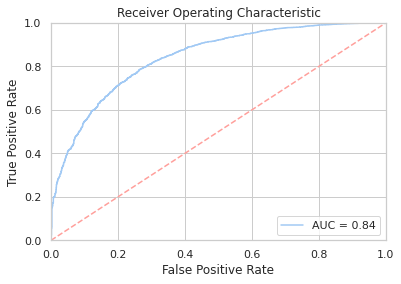

In [96]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs
  
# Compute predicted probabilities on the val set
probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test_sent)

In [100]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data_cleaned.Text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [102]:
# Nr. of non-neg reviews
print("Number of reviews positive", test_data_cleaned[test_data_cleaned["Label"]==1].shape[0])
print("Number of reviews negative", test_data_cleaned[test_data_cleaned["Label"]==0].shape[0])

Number of reviews positive 6422
Number of reviews negative 1633


In [107]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

Number of reviews predicted positive:  6397
AUC: 0.5462
Accuracy: 79.69%


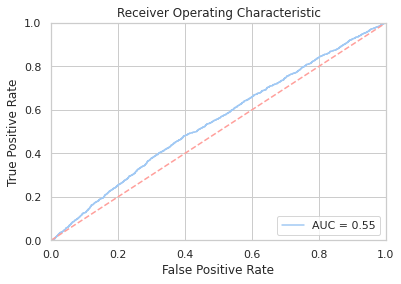

In [110]:
# Get predictions from the probabilities
threshold = 0.54
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of reviews predicted positive: ", preds.sum())

# Evaluate the Bert classifier
results_sentiment['BERT_Eval'] = evaluate_roc(probs, test_data_cleaned.Label)

In [112]:
#Get the confusion matrix
cf_matrix = confusion_matrix(test_data_cleaned.Label, preds)
print(cf_matrix)

[[ 393 1240]
 [1265 5157]]


In [ ]:
#results_sentiment['BERT'] = {"Number of reviews predicted non-negative": 6321, "AUC": 0.8449, "Accuracy": 0.8426}

[[ 393 1240]
 [1265 5157]]


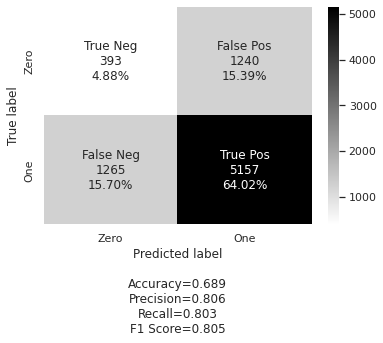

In [113]:
#Get the confusion matrix
cf_matrix = confusion_matrix(test_data_cleaned.Label, preds)
print(cf_matrix)

labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Zero", "One"]

# Metrics
accuracy, precision, recall, f1_score = make_confusion_matrix(cf_matrix, 
                                                              group_names=labels,
                                                              categories=categories, 
                                                              cmap='binary')
results_sentiment["BERT"] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score':f1_score}

In [114]:
results_sentiment_df = pd.DataFrame(results_sentiment, index=[0]).transpose()

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/results_sentiment_review_level.xlsx')

results_sentiment_df.to_excel(writer, sheet_name="sentiment_analysis")

writer.save()

## Final Sentiment Predictions

In [116]:
# Final predictions on test data from best model
sent_pred_final = preds

# Extractive Summarisation

In [143]:
# Concatenate all data together
all_data = pd.concat([train_data_cleaned, test_data_cleaned])

# Original labels
all_data_og = all_data
#test_data_og = test_data_cleaned

# Predicted labels
all_data_pred = all_data.copy()
#all_data_pred["Aspect"] = aspect_pred_final
#all_data_pred["Label"] = sent_pred_final
#test_data_pred = test_data_cleaned.copy()
#test_data_pred["Aspect"] = aspect_pred_final
#test_data_pred["Label"] = sent_pred_final

print("Shape of all_data: ", all_data.shape[0])
print("Shape of test_data_cleaned: ", test_data_cleaned.shape[0])

Shape of all_data:  40024
Shape of test_data_cleaned:  8055


## Create input documents

In [148]:
# TEST DATA OG

test_data_og = pd.DataFrame(columns=["Venue", "Aspect", "Sentiment", "Input", "Gensim_summary"])
temp_df = pd.DataFrame(columns=["Venue", "Aspect", "Sentiment", "Input", "Gensim_summary"])
venue_lst = []
aspect_lst = []
sent_lst = []
input_lst = []


for v in test_data_cleaned["Venue"].unique():
    venue_df = test_data_cleaned[test_data_cleaned["Venue"]==v]
    for a in venue_df["Aspect"].unique():
        aspect_df = venue_df[venue_df["Aspect"]==a]
        for sent in aspect_df["Sentiment"].unique():
            sent_df = aspect_df[aspect_df["Sentiment"]==sent]
            input = ' '.join(sent_df.Text).replace('\n', '').replace('.', '. ').replace('  ', ' ')
            # Count nr. of sentences in the input and set a threshold of 6 sentences
            if len(sent_tokenize(input)) > 10:
                venue_lst.append(v)
                aspect_lst.append(a)
                sent_lst.append(sent)
                input_lst.append(input)

test_data_og["Venue"] = venue_lst
test_data_og["Aspect"] = aspect_lst
test_data_og["Sentiment"] = sent_lst
test_data_og["Input"] = input_lst

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/test_data_og.xlsx')

test_data_og.to_excel(writer, sheet_name="summary_text")

writer.save()

In [157]:
# ALL DATA OG

all_data_og = pd.DataFrame(columns=["Venue", "Aspect", "Sentiment", "Input", "Gensim_summary"])
temp_df = pd.DataFrame(columns=["Venue", "Aspect", "Sentiment", "Input", "Gensim_summary"])
venue_lst = []
aspect_lst = []
sent_lst = []
input_lst = []


for v in all_data["Venue"].unique():
    venue_df = all_data[all_data["Venue"]==v]
    for a in venue_df["Aspect"].unique():
        aspect_df = venue_df[venue_df["Aspect"]==a]
        for sent in aspect_df["Sentiment"].unique():
            sent_df = aspect_df[aspect_df["Sentiment"]==sent]
            input = ' '.join(sent_df.Text).replace('\n', '').replace('.', '. ').replace('  ', ' ')
            # Count nr. of sentences in the input and set a threshold of 6 sentences
            if len(sent_tokenize(input)) > 6:
                venue_lst.append(v)
                aspect_lst.append(a)
                sent_lst.append(sent)
                input_lst.append(input)

all_data_og["Venue"] = venue_lst
all_data_og["Aspect"] = aspect_lst
all_data_og["Sentiment"] = sent_lst
all_data_og["Input"] = input_lst

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/all_data_og.xlsx')

all_data_og.to_excel(writer, sheet_name="summary_text")

writer.save()

In [ ]:
writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/all_data_pred.xlsx')

all_data_pred.to_excel(writer, sheet_name="summary_text")

writer.save()

3461

In [ ]:
writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/test_data_pred.xlsx')

test_data_pred.to_excel(writer, sheet_name="summary_text")

writer.save()

## Evaluation

In [142]:
# Summary Evaluation

# Creating a dictionary and corpus
def create_corpus(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Isolate and remove punctuations
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    - Create dictionary
    - Create corpus
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations
    s = re.sub(r'[^\w\s]','',s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    tokens = word_tokenize(s)

    dictionary = Dictionary([tokens])

    corpus = [dictionary.doc2bow(text) for text in [tokens]]

    return dictionary, corpus

# Evaluate with Distance Metrics
def distance_metrics(input, output):
    stop_words = stopwords.words('english')
    dictionary, corpus = create_corpus(input)

    np.random.seed(1)

    model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=2, minimum_probability=1e-8)

    input_lst = [word for word in word_tokenize(input) if not word.lower() in stop_words]
    output_lst = [word for word in word_tokenize(output) if not word.lower() in stop_words]

    # now let's make these into a bag of words format
    bow_input = model.id2word.doc2bow(input_lst)
    bow_output = model.id2word.doc2bow(output_lst)

    # we can now get the LDA topic distributions for these
    lda_input = model[bow_input]
    lda_output = model[bow_output]

    kull = kullback_leibler(lda_input, lda_output)

    jens = distance.jensenshannon(lda_input, lda_output)

    return kull, jens[1]

## TextRank

In [162]:
all_data_og['Input'].iloc[0]

"Good all round access, the museum garden area has a couple of short steeper slopes that manual chair users may need a hand with but generally good. Level floors and gentle ramps throughout the building. Paved pathway to the archaeological dig as well Jen 33 describes the access very well in a review from 2015 - see https://www. euansguide. com/venues/vindolanda-hexham-1058/reviews/good-access-and-alternatives-provided-2198. Everything written there still holds true in 2018, including the staff being eager to explain about the steep path below the ruins and offer alternative ways to get down to the museum and cafe.  I was able to get up close to the ruins in my small scooter and even got some of the way along the battered Roman paths. The modern paths skirting the ruins had good, level tarmac - just a shame there wasn't one of these paths to get wheelchairs over for a look at the part of the site where people are doing live archaeological work.  I'd also like to say that the museum at 

In [163]:
# ALL DATA OG

from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from gensim.summarization.textcleaner import get_sentences, split_sentences

# Create summaies with gensim
output_lst = []

for input in all_data_og["Input"]:
    nr_words = (len(word_tokenize(input)))
 
    try:
        output = summarize(input, word_count=50).replace('\n', '').replace('.', '. ')
        if output == '':
            output = input
    except:
        output_lst.append(input)
    else:
        output_lst.append(output)

all_data_og["Gensim_summary"] = output_lst

In [ ]:
# Evaluate gensim summaries
input_lst = summary_df["Input"]
output_lst = summary_df["Summary"]

kull_lst = []
jens_lst = []

for i in range(len(input_lst)):
    try:
        kull, jens = distance_metrics(input_lst[i], output_lst[i])
    except:
        kull, jens = -1, -1
        kull_lst.append(kull)
        jens_lst.append(jens)
    else:
        kull_lst.append(kull)
        jens_lst.append(jens)

all_data_og["kullback_leibler"] = kull_lst
summary_df["jensen_shannon"] = jens_lst

In [ ]:
writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/all_data_og_intermediate.xlsx')

all_data_og.to_excel(writer, sheet_name="summaries")

writer.save()

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/all_data_pred_intermediate.xlsx')

all_data_pred.to_excel(writer, sheet_name="summaries")

writer.save()

## BERT

In [ ]:
# Initialize models
model_bert = Summarizer()
model_distilbert = Summarizer('distilbert-base-uncased', hidden=[-1,-2], hidden_concat=True)
model_sbert = SBertSummarizer('paraphrase-MiniLM-L6-v2')

In [ ]:
def generate_summary_BERT(df, model):
    output_lst = []

    for input in df["Input"]:
        nr_sentences = (len(sent_tokenize(input)))
    
        try:
            output = model(input, num_sentences=3).replace('\n', '').replace('.', '. ')
            if output == '':
                output = input
        except:
            output_lst.append(input)
        else:
            output_lst.append(output)
    
    return output_lst

### BERT Summarizer

In [ ]:
writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/all_data_og_intermediate.xlsx')

all_data_og.to_excel(writer, sheet_name="summaries")

writer.save()

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/all_data_pred_intermediate.xlsx')

all_data_pred.to_excel(writer, sheet_name="summaries")

writer.save()

### Distil BERT

In [ ]:
writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/all_data_og_intermediate.xlsx')

all_data_og.to_excel(writer, sheet_name="summaries")

writer.save()

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/all_data_pred_intermediate.xlsx')

all_data_pred.to_excel(writer, sheet_name="summaries")

writer.save()

### SBERT

In [ ]:
writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/all_data_og_intermediate.xlsx')

all_data_og.to_excel(writer, sheet_name="summaries")

writer.save()

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/all_data_pred_intermediate.xlsx')

all_data_pred.to_excel(writer, sheet_name="summaries")

writer.save()

## Save all summaries

In [ ]:
writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/all_data_og_final.xlsx')

all_data_og.to_excel(writer, sheet_name="summaries")

writer.save()

writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/all_data_pred_final.xlsx')

all_data_pred.to_excel(writer, sheet_name="summaries")

writer.save()

## Evaluation of summaries

In [178]:
path = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/"
gensim_summaries_all_data = pd.read_excel(path + 'gensim_summaries_all_data.xlsx').rename(columns={"Unnamed: 0": "Index"})
bert_summaries_all_data = pd.read_excel(path + 'bert_summaries_all_data.xlsx').rename(columns={"Unnamed: 0": "Index"})
distilbert_summaries_all_data = pd.read_excel(path + 'distilbert_summaries_all_data.xlsx').rename(columns={"Unnamed: 0": "Index"})
sbert_summaries_all_data = pd.read_excel(path + 'sbert_summaries_all_data.xlsx').rename(columns={"Unnamed: 0": "Index"})

In [179]:
gensim_summaries_all_data.head()

,Index,Venue,Aspect,Sentiment,Input,Summary,kullback_leibler,jensen_shannon,Target,Label
0,0.0,leuchie house north berwick,Transport & Parking,positive,Ample parking spaces and space. It is a beauti...,There is ample parking including disabled park...,0.008352,0.049038,2,1
1,1.0,leuchie house north berwick,Access,positive,Disabled access is very good. Although Leuchi...,They had to use lift to 2nd and 3rd floor From...,0.027544,0.078816,1,1
2,2.0,leuchie house north berwick,Overview,positive,Grace staff/venue/quality of care. Within 24 h...,The staff and volunteers at Leuchie did all th...,0.023189,0.077067,0,1
3,3.0,leuchie house north berwick,Staff,positive,All the staff and volunteers were very helpful...,All the staff and volunteers were very helpful...,0.013550,0.064499,4,1
4,4.0,leuchie house north berwick,Toilets,positive,All loos are accessible with plenty of room fo...,On the lower ground level there is a second to...,0.016822,0.070738,3,1


In [182]:
def summary_metrics(df):

    # KL
    average_KL = np.mean(df["kullback_leibler"])
    max_KL = np.max(df["kullback_leibler"])
    min_KL = np.min(df["kullback_leibler"])

    # JS
    average_JS = np.mean(df["jensen_shannon"])
    max_JS = np.max(df["jensen_shannon"])
    min_JS = np.min(df["jensen_shannon"])

    metric_KL = {"KL": {'average': average_KL, 'max': max_KL, 'min': min_KL}}
    metric_JS = {"JS": {'average': average_JS, 'max': max_JS, 'min': min_JS}}

    return metric_KL, metric_JS

In [213]:
results_genism = summary_metrics(gensim_summaries_all_data)
print(results_genism)

# Find metrics per sentiment
results_genism_sent = {}
results_genism_sent['positive'] = {}
results_genism_sent['negative'] = {}
for s in gensim_summaries_all_data["Sentiment"].unique():
    dff = gensim_summaries_all_data[gensim_summaries_all_data["Sentiment"] == s]

    results_genism_sent[s] = summary_metrics(dff)

print(results_genism_sent)

# Find metrics per aspect
results_genism_aspect = {}
results_genism_aspect['Overview'] = {}
results_genism_aspect['Access'] = {}
results_genism_aspect['Transport & Parking'] = {}
results_genism_aspect['Staff'] = {}
results_genism_aspect['Toilets'] = {}
for a in gensim_summaries_all_data["Aspect"].unique():
    dff = gensim_summaries_all_data[gensim_summaries_all_data["Aspect"] == a]

    results_genism_aspect[a] = summary_metrics(dff)

print(results_genism_aspect)

({'KL': {'average': 0.05768429194317113, 'max': 1.604149699211121, 'min': -8.195547707146034e-08}}, {'JS': {'average': 0.08937353879465376, 'max': 0.5659863625155918, 'min': 4.046577937640532e-06}})
{'positive': ({'KL': {'average': 0.054856697101191974, 'max': 1.604149699211121, 'min': -8.195547707146034e-08}}, {'JS': {'average': 0.08705338186047495, 'max': 0.5659863625155918, 'min': 4.046577937640532e-06}}), 'negative': ({'KL': {'average': 0.06919767812025547, 'max': 0.9892755746841431, 'min': 6.669779395451769e-09}}, {'JS': {'average': 0.09882074190100286, 'max': 0.4869386848633934, 'min': 6.133202794081434e-06}})}
{'Overview': ({'KL': {'average': 0.06505180658461461, 'max': 1.604149699211121, 'min': -8.195547707146034e-08}}, {'JS': {'average': 0.09327443740124605, 'max': 0.5659863625155918, 'min': 4.046577937640532e-06}}), 'Access': ({'KL': {'average': 0.05395926310703567, 'max': 1.187363862991333, 'min': 6.100744940340519e-07}}, {'JS': {'average': 0.08986685572485109, 'max': 0.5274

In [214]:
results_BERT = summary_metrics(bert_summaries_all_data)
print(results_BERT)

# Find metrics per sentiment
results_BERT_sent = {}
results_BERT_sent['positive'] = {}
results_BERT_sent['negative'] = {}
for s in bert_summaries_all_data["Sentiment"].unique():
    dff = bert_summaries_all_data[bert_summaries_all_data["Sentiment"] == s]

    results_BERT_sent[s] = summary_metrics(dff)

print(results_BERT_sent)

# Find metrics per aspect
results_BERT_aspect = {}
results_BERT_aspect['Overview'] = {}
results_BERT_aspect['Access'] = {}
results_BERT_aspect['Transport & Parking'] = {}
results_BERT_aspect['Staff'] = {}
results_BERT_aspect['Toilets'] = {}
for a in bert_summaries_all_data["Aspect"].unique():
    dff = bert_summaries_all_data[bert_summaries_all_data["Aspect"] == a]

    results_BERT_aspect[a] = summary_metrics(dff)

print(results_BERT_aspect)

({'KL': {'average': 0.05304648787157036, 'max': 1.556218504905701, 'min': 7.660128176212311e-08}}, {'JS': {'average': 0.08701570241003759, 'max': 0.6050127450117583, 'min': 0.0001714768702973009}})
{'positive': ({'KL': {'average': 0.05165947157991615, 'max': 1.353567004203796, 'min': 7.660128176212311e-08}}, {'JS': {'average': 0.08679695785955562, 'max': 0.5081122510727576, 'min': 0.0001714768702973009}}), 'negative': ({'KL': {'average': 0.058694133695023944, 'max': 1.556218504905701, 'min': 9.915675036609173e-06}}, {'JS': {'average': 0.08790638534892373, 'max': 0.6050127450117583, 'min': 0.001573955635562067}})}
{'Overview': ({'KL': {'average': 0.053394360151036914, 'max': 1.353567004203796, 'min': 8.373608579859138e-07}}, {'JS': {'average': 0.08811701302466697, 'max': 0.5017598447241469, 'min': 0.0004386071688557312}}), 'Access': ({'KL': {'average': 0.057192878460344404, 'max': 1.556218504905701, 'min': 3.181630745530128e-06}}, {'JS': {'average': 0.08892197644370411, 'max': 0.6050127

In [215]:
results_distilbert = summary_metrics(distilbert_summaries_all_data)
print(results_distilbert)

# Find metrics per sentiment
results_distilbert_sent = {}
results_distilbert_sent['positive'] = {}
results_distilbert_sent['negative'] = {}
for s in distilbert_summaries_all_data["Sentiment"].unique():
    dff = distilbert_summaries_all_data[distilbert_summaries_all_data["Sentiment"] == s]

    results_distilbert_sent[s] = summary_metrics(dff)

print(results_distilbert_sent)

# Find metrics per aspect
results_distilbert_aspect = {}
results_distilbert_aspect['Overview'] = {}
results_distilbert_aspect['Access'] = {}
results_distilbert_aspect['Transport & Parking'] = {}
results_distilbert_aspect['Staff'] = {}
results_distilbert_aspect['Toilets'] = {}
for a in distilbert_summaries_all_data["Aspect"].unique():
    dff = distilbert_summaries_all_data[distilbert_summaries_all_data["Aspect"] == a]

    results_distilbert_aspect[a] = summary_metrics(dff)

print(results_distilbert_aspect)

({'KL': {'average': 0.051909250786357136, 'max': 1.239574551582336, 'min': 1.127773430198431e-08}}, {'JS': {'average': 0.08474577579077572, 'max': 0.5379023393362399, 'min': 0.0001182908506268736}})
{'positive': ({'KL': {'average': 0.05164204027968657, 'max': 1.239574551582336, 'min': 3.181630745530128e-06}}, {'JS': {'average': 0.08488462450237871, 'max': 0.5379023393362399, 'min': 0.0008933376026794914}}), 'negative': ({'KL': {'average': 0.05299727715710805, 'max': 1.230485916137695, 'min': 1.127773430198431e-08}}, {'JS': {'average': 0.08418041231891477, 'max': 0.5270421000022651, 'min': 0.0001182908506268736}})}
{'Overview': ({'KL': {'average': 0.05317202303302538, 'max': 1.142797231674194, 'min': 1.127773430198431e-08}}, {'JS': {'average': 0.08528237005133334, 'max': 0.4782676532433227, 'min': 0.0001182908506268736}}), 'Access': ({'KL': {'average': 0.05627821631092863, 'max': 1.230485916137695, 'min': 6.530026439577341e-07}}, {'JS': {'average': 0.08763588182369568, 'max': 0.53790233

In [216]:
results_sbert = summary_metrics(sbert_summaries_all_data)
print(results_sbert)

# Find metrics per sentiment
results_sbert_sent = {}
results_sbert_sent['positive'] = {}
results_sbert_sent['negative'] = {}
for s in sbert_summaries_all_data["Sentiment"].unique():
    dff = sbert_summaries_all_data[sbert_summaries_all_data["Sentiment"] == s]

    results_sbert_sent[s] = summary_metrics(dff)

print(results_sbert_sent)

# Find metrics per aspect
results_sbert_aspect = {}
results_sbert_aspect['Overview'] = {}
results_sbert_aspect['Access'] = {}
results_sbert_aspect['Transport & Parking'] = {}
results_sbert_aspect['Staff'] = {}
results_sbert_aspect['Toilets'] = {}
for a in sbert_summaries_all_data["Aspect"].unique():
    dff = sbert_summaries_all_data[sbert_summaries_all_data["Aspect"] == a]

    results_sbert_aspect[a] = summary_metrics(dff)

print(results_sbert_aspect)

({'KL': {'average': 0.046995886971426475, 'max': 1.308675527572632, 'min': 1.127773430198431e-08}}, {'JS': {'average': 0.08157832564557359, 'max': 0.5351171816021756, 'min': 0.0001182908506268736}})
{'positive': ({'KL': {'average': 0.04478621368546026, 'max': 1.308675527572632, 'min': 3.192981239408255e-07}}, {'JS': {'average': 0.08091851601949909, 'max': 0.5232403827039235, 'min': 0.0002825170630808439}}), 'negative': ({'KL': {'average': 0.055993223325565805, 'max': 1.117371082305908, 'min': 1.127773430198431e-08}}, {'JS': {'average': 0.08426493509738409, 'max': 0.5351171816021756, 'min': 0.0001182908506268736}})}
{'Overview': ({'KL': {'average': 0.04634576374027163, 'max': 1.107050061225891, 'min': 1.127773430198431e-08}}, {'JS': {'average': 0.08036151371448211, 'max': 0.5232403827039235, 'min': 0.0001182908506268736}}), 'Access': ({'KL': {'average': 0.051137388642741706, 'max': 1.308675527572632, 'min': 6.787740858271718e-07}}, {'JS': {'average': 0.08515566227335811, 'max': 0.522912

In [228]:
results_summaries = {}
results_summaries['Gensim'] = results_genism
results_summaries['Gensim_sentiment'] = results_genism_sent
results_summaries['Gensim_aspect'] = results_genism_aspect

results_summaries['BERT'] = results_BERT
results_summaries['BERT_sentiment'] = results_BERT_sent
results_summaries['BERT_aspect'] = results_BERT_aspect

results_summaries['distilBERT'] = results_distilbert
results_summaries['distilBERT_sentiment'] = results_distilbert_sent
results_summaries['distilBERT_aspect'] = results_distilbert_aspect

results_summaries['SBERT'] = results_sbert
results_summaries['SBERT_sentiment'] = results_sbert_sent
results_summaries['SBERT_aspect'] = results_sbert_aspect

with open('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/results_summaries.csv', 'w') as f:
  for key in results_summaries.keys():
    f.write("%s,%s\n"%(key,results_summaries[key]))

#results_summaries_df = pd.DataFrame(results_summaries.Transpose())

#writer = pd.ExcelWriter('/content/drive/MyDrive/Colab_Notebooks/Thesis/Results/results_summaries.xlsx')

#results_summaries_df.to_excel(writer, sheet_name="results_summaries")

#writer.save()

In [222]:
results_summaries

{'BERT': ({'KL': {'average': 0.05304648787157036,
    'max': 1.556218504905701,
    'min': 7.660128176212311e-08}},
  {'JS': {'average': 0.08701570241003759,
    'max': 0.6050127450117583,
    'min': 0.0001714768702973009}}),
 'BERT_aspect': {'Access': ({'KL': {'average': 0.057192878460344404,
     'max': 1.556218504905701,
     'min': 3.181630745530128e-06}},
   {'JS': {'average': 0.08892197644370411,
     'max': 0.6050127450117583,
     'min': 0.0008933376026794914}}),
  'Overview': ({'KL': {'average': 0.053394360151036914,
     'max': 1.353567004203796,
     'min': 8.373608579859138e-07}},
   {'JS': {'average': 0.08811701302466697,
     'max': 0.5017598447241469,
     'min': 0.0004386071688557312}}),
  'Staff': ({'KL': {'average': 0.06012407550068539,
     'max': 0.7549422979354858,
     'min': 9.915675036609173e-06}},
   {'JS': {'average': 0.08868576532482579,
     'max': 0.4551891868961689,
     'min': 0.001573955635562067}}),
  'Toilets': ({'KL': {'average': 0.04516706006812318,


In [210]:
# Find metrics per sentiment
results_genism_sent = {}
results_genism_sent['positive'] = {}
results_genism_sent['negative'] = {}
for s in gensim_summaries_all_data["Sentiment"].unique():
    dff = gensim_summaries_all_data[gensim_summaries_all_data["Sentiment"] == s]

    results_genism_sent[s] = summary_metrics(dff)

# Find metrics per aspect
results_genism_aspect = {}
results_genism_aspect['Overview'] = {}
results_genism_aspect['Access'] = {}
results_genism_aspect['Transport & Parking'] = {}
results_genism_aspect['Staff'] = {}
results_genism_aspect['Toilets'] = {}
for a in gensim_summaries_all_data["Aspect"].unique():
    dff = gensim_summaries_all_data[gensim_summaries_all_data["Sentiment"] == s]

    results_genism_aspect[a] = summary_metrics(dff)

In [208]:
results_genism_sent

{'negative': ({'KL': {'average': 0.06919767812025547,
    'max': 0.9892755746841431,
    'min': 6.669779395451769e-09}},
  {'JS': {'average': 0.09882074190100286,
    'max': 0.4869386848633934,
    'min': 6.133202794081434e-06}}),
 'positive': ({'KL': {'average': 0.054856697101191974,
    'max': 1.604149699211121,
    'min': -8.195547707146034e-08}},
  {'JS': {'average': 0.08705338186047495,
    'max': 0.5659863625155918,
    'min': 4.046577937640532e-06}})}

In [211]:
results_genism_aspect

{'Access': ({'KL': {'average': 0.06919767812025547,
    'max': 0.9892755746841431,
    'min': 6.669779395451769e-09}},
  {'JS': {'average': 0.09882074190100286,
    'max': 0.4869386848633934,
    'min': 6.133202794081434e-06}}),
 'Overview': ({'KL': {'average': 0.06919767812025547,
    'max': 0.9892755746841431,
    'min': 6.669779395451769e-09}},
  {'JS': {'average': 0.09882074190100286,
    'max': 0.4869386848633934,
    'min': 6.133202794081434e-06}}),
 'Staff': ({'KL': {'average': 0.06919767812025547,
    'max': 0.9892755746841431,
    'min': 6.669779395451769e-09}},
  {'JS': {'average': 0.09882074190100286,
    'max': 0.4869386848633934,
    'min': 6.133202794081434e-06}}),
 'Toilets': ({'KL': {'average': 0.06919767812025547,
    'max': 0.9892755746841431,
    'min': 6.669779395451769e-09}},
  {'JS': {'average': 0.09882074190100286,
    'max': 0.4869386848633934,
    'min': 6.133202794081434e-06}}),
 'Transport & Parking': ({'KL': {'average': 0.06919767812025547,
    'max': 0.9892